sklearn-feature-selection: 

https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

Feature Importance:

https://machinelearningmastery.com/calculate-feature-importance-with-python/

ANOVA F-Test: 

https://towardsdatascience.com/1-way-anova-from-scratch-dissecting-the-anova-table-with-a-worked-example-170f4f2e58ad

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif

Unvariate Regression F-Test:

https://www.statology.org/f-test-python/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression


Chi Square:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

https://medium.com/analytics-vidhya/pearsons-chi-squared-test-from-scratch-with-python-ba9e14d336c


Comparison F-test vs Mutual Info:

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py


Mutual Information Gain:

https://machinelearningmastery.com/information-gain-and-mutual-information/

https://www.youtube.com/watch?v=U9h1xkNELvY


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/00 - Data Processing/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/00 - Data Processing


In [ ]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import (SelectKBest, chi2, f_classif, SequentialFeatureSelector,
                                       mutual_info_classif, SelectFromModel)
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv('./data/train.csv')
X = df.iloc[:, 0 : -1]
y = df.iloc[:, -1]
df.head()

battery_power  blue  clock_speed  ...  touch_screen  wifi  price_range
0            842     0          2.2  ...             0     1            1
1           1021     1          0.5  ...             1     0            2
2            563     1          0.5  ...             1     0            2
3            615     1          2.5  ...             0     0            2
4           1821     1          1.2  ...             1     0            1

[5 rows x 21 columns]

# Select Kbest (Chi 2)

In [ ]:
# SelectKBest class to extract top 10 best features 
# bestfeatures = SelectKBest(score_func=chi2, k=10)
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score'] # naming the dataframe columns
print(featureScores.nlargest(10, 'Score')) # print 10 best features

            Specs     Score
13            ram  0.847633
0   battery_power  0.032003
12       px_width  0.028139
5          four_g  0.023691
11      px_height  0.022790
8       mobile_wt  0.017015
17        three_g  0.015666
19           wifi  0.012429
2     clock_speed  0.010963
14           sc_h  0.009294


# Recursive feature elimination

https://scikit-learn.org/stable/modules/feature_selection.html#rfe

https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# eliminate one feature with lowest coef/feature importance every iteration
# use RFECV to automatically Select the Number of Features

model = GradientBoostingClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# RFECV(estimator=model, step=1, cv=cv)
rfe = RFE(estimator=model, n_features_to_select=3, step=1)
rfe.fit(X, y)
df = pd.DataFrame({'Features': X.columns, "Support": rfe.support_, "Ranking":rfe.ranking_})
df.sort_values('Ranking').head(5)

Features  Support  Ranking
0   battery_power     True        1
13            ram     True        1
11      px_height     True        1
12       px_width    False        2
8       mobile_wt    False        3

# Select from Model (Tree Based)

Feature importance(Tree Based) is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

This approach applicable to TreeBased (feature importance) & Regression (coef)

[0.06026731 0.02013249 0.03325304 0.01986165 0.03201047 0.01714523
 0.03637516 0.03456975 0.03701849 0.03428025 0.03456379 0.04838101
 0.04844599 0.38299658 0.03475558 0.03541874 0.0362644  0.01462359
 0.01849593 0.02114055]


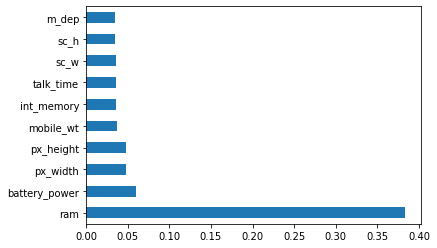

In [ ]:
# ensemble tree base
clf = ExtraTreesClassifier()
clf.fit(X, y)
print(clf.feature_importances_)
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

# Permutation Feature Importance

Suits the models which doesn't provide feature importance score. It scrambled the values of a feature to find the importance score (baseline - permutated performance)

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

In [ ]:
model = KNeighborsClassifier()
model.fit(X, y)
results = permutation_importance(model, X.values, y.values, scoring='accuracy', max_samples=0.5, n_repeats=5)
print(results.importances_mean)
pd.DataFrame({'FeatureName': X.columns, "ImportanceScore": results.importances_mean}).sort_values('ImportanceScore', ascending=False).head(5)

[ 0.2038 -0.004  -0.004  -0.004  -0.004  -0.004  -0.0034 -0.004  -0.002
 -0.004  -0.004   0.0846  0.0888  0.6862 -0.004  -0.004  -0.004  -0.004
 -0.004  -0.004 ]


FeatureName  ImportanceScore
13            ram           0.6862
0   battery_power           0.2038
12       px_width           0.0888
11      px_height           0.0846
8       mobile_wt          -0.0020

# Sequential Feature Selection

Fundamentally differes from RFE, it does not require the underlying model to expose a coef_ or feature_importances_ attribute

https://scikit-learn.org/0.24/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

In [ ]:
# start with 1 feature and increase
clf = ExtraTreesClassifier()
clf.fit(X, y)

sfs_forward = SequentialFeatureSelector(clf, n_features_to_select=2, 
                                        direction='forward').fit(X, y)

# start with max feature and decrease
sfs_backward = SequentialFeatureSelector(clf, n_features_to_select=2,
                                         direction='backward').fit(X, y)

print("Features selected by forward sequential selection: "
      f"{X.columns[sfs_forward.get_support()]}")
print("Features selected by backward sequential selection: "
      f"{X.columns[sfs_backward.get_support()]}")

Features selected by forward sequential selection: Index(['battery_power', 'ram'], dtype='object')
Features selected by backward sequential selection: Index(['battery_power', 'ram'], dtype='object')


# Auto Encoder

https://www.v7labs.com/blog/autoencoders-guide

https://machinelearningmastery.com/autoencoder-for-classification/

# Correlation Heatmap

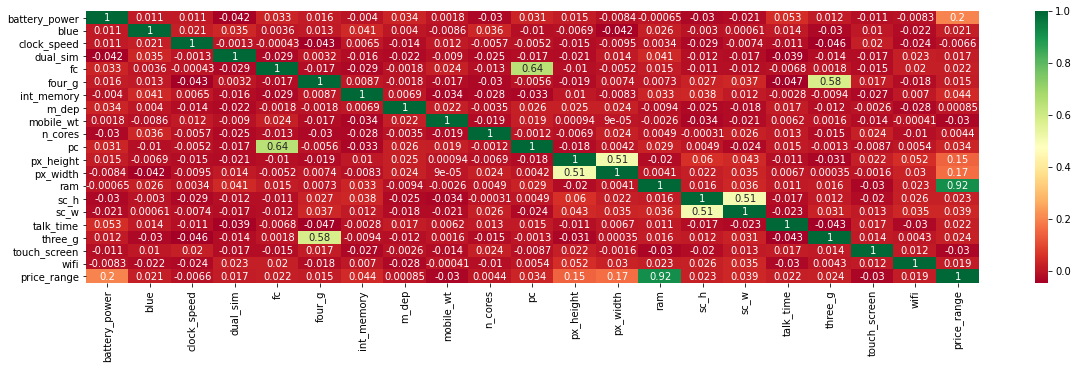

In [ ]:
0.00000=corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,5))
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")